## Hyperparameter Sweep for CBGM vs. scCBGM

In [18]:
import wandb
import pandas as pd
import seaborn as sns
import conceptlab as clab

import matplotlib.pyplot as plt
import yaml

import os.path as osp
import numpy as np

In [2]:
OUT_DIR = '../../../results/hp_sweep/'
raw_filename = 'cbgm_vs_sccbgm_hp_sweep.csv'

In [3]:
with open('wandb_info.txt') as f:
    wandb_user_name = f.readlines()[0]

DOWNLOAD = False

In [4]:
raw_path = osp.join(OUT_DIR, raw_filename)

if osp.isfile(raw_path) and not DOWNLOAD:

    _df = pd.read_csv(raw_path, index_col=0, header=0)
else:
    entity, project = wandb_user_name, "clab_hparam_sweep"
    _df = clab.utils.wandb.download_wandb_project(project, entity)
    _df.to_csv(
        raw_path,
    )

In [5]:
df = _df.copy()

In [6]:
df['model'] = df['model'].map({'scCBGM':'scCBGM','cem_vae':'CBGM'})

In [7]:
hp_columns = [
    "model.lr",
    "model.beta",
    "model.n_layers",
    "model.concepts_hp",
    "model.hidden_dim",
    "model.min_bottleneck_size",
    "model.latent_dim",
    "model.orthogonality_hp",
]

grp_columns = ["intervention", "seed"]

meta_columns = ["model", "intervention"]

metric_columns = ["MSE_intervened"]

use_columns = hp_columns + meta_columns + metric_columns + grp_columns

In [8]:
df['hp_list'] = df[hp_columns].apply(tuple, axis =1)

In [9]:
scCBGM_df = df[df['model'].values == 'scCBGM'].copy()
CBGM_df = df[df['model'].values == 'CBGM'].copy()

In [10]:
scCBGM_df = scCBGM_df[['hp_list'] + metric_columns].groupby('hp_list').agg('mean')
scCBGM_df = scCBGM_df.sort_values('MSE_intervened')
scCBGM_df = scCBGM_df.reset_index()

In [11]:
CBGM_df = CBGM_df[['hp_list'] + metric_columns].groupby('hp_list').agg('mean')
CBGM_df = CBGM_df.sort_values('MSE_intervened')
CBGM_df = CBGM_df.reset_index()

In [12]:
out_values = dict()
for model_name, sweep_values in zip(["scCBGM", "CBGM"], [scCBGM_df, CBGM_df]):
    out_values[model_name] = {
        h.replace("model.", ""): v
        for h, v in zip(hp_columns, sweep_values["hp_list"].iloc[0])
    }

In [13]:
for model_name, hp_dict in out_values.items():
    with open(osp.join(OUT_DIR, model_name + ".yaml"), "w") as f:
        yaml.dump(hp_dict, f, default_flow_style=False, sort_keys=False)

In [23]:
plot_columns = ["model", "MSE_intervened", "intervention"]
plot_df = df[plot_columns].copy()

In [29]:
plot_df['intervention_num'] = plot_df['intervention'].apply(lambda x:x.replace('synthetic/intervention_',''))

In [30]:
%matplotlib inline

In [32]:
cmap = {'CBGM':'#20a39e', 'scCBGM':'#ffba49'}

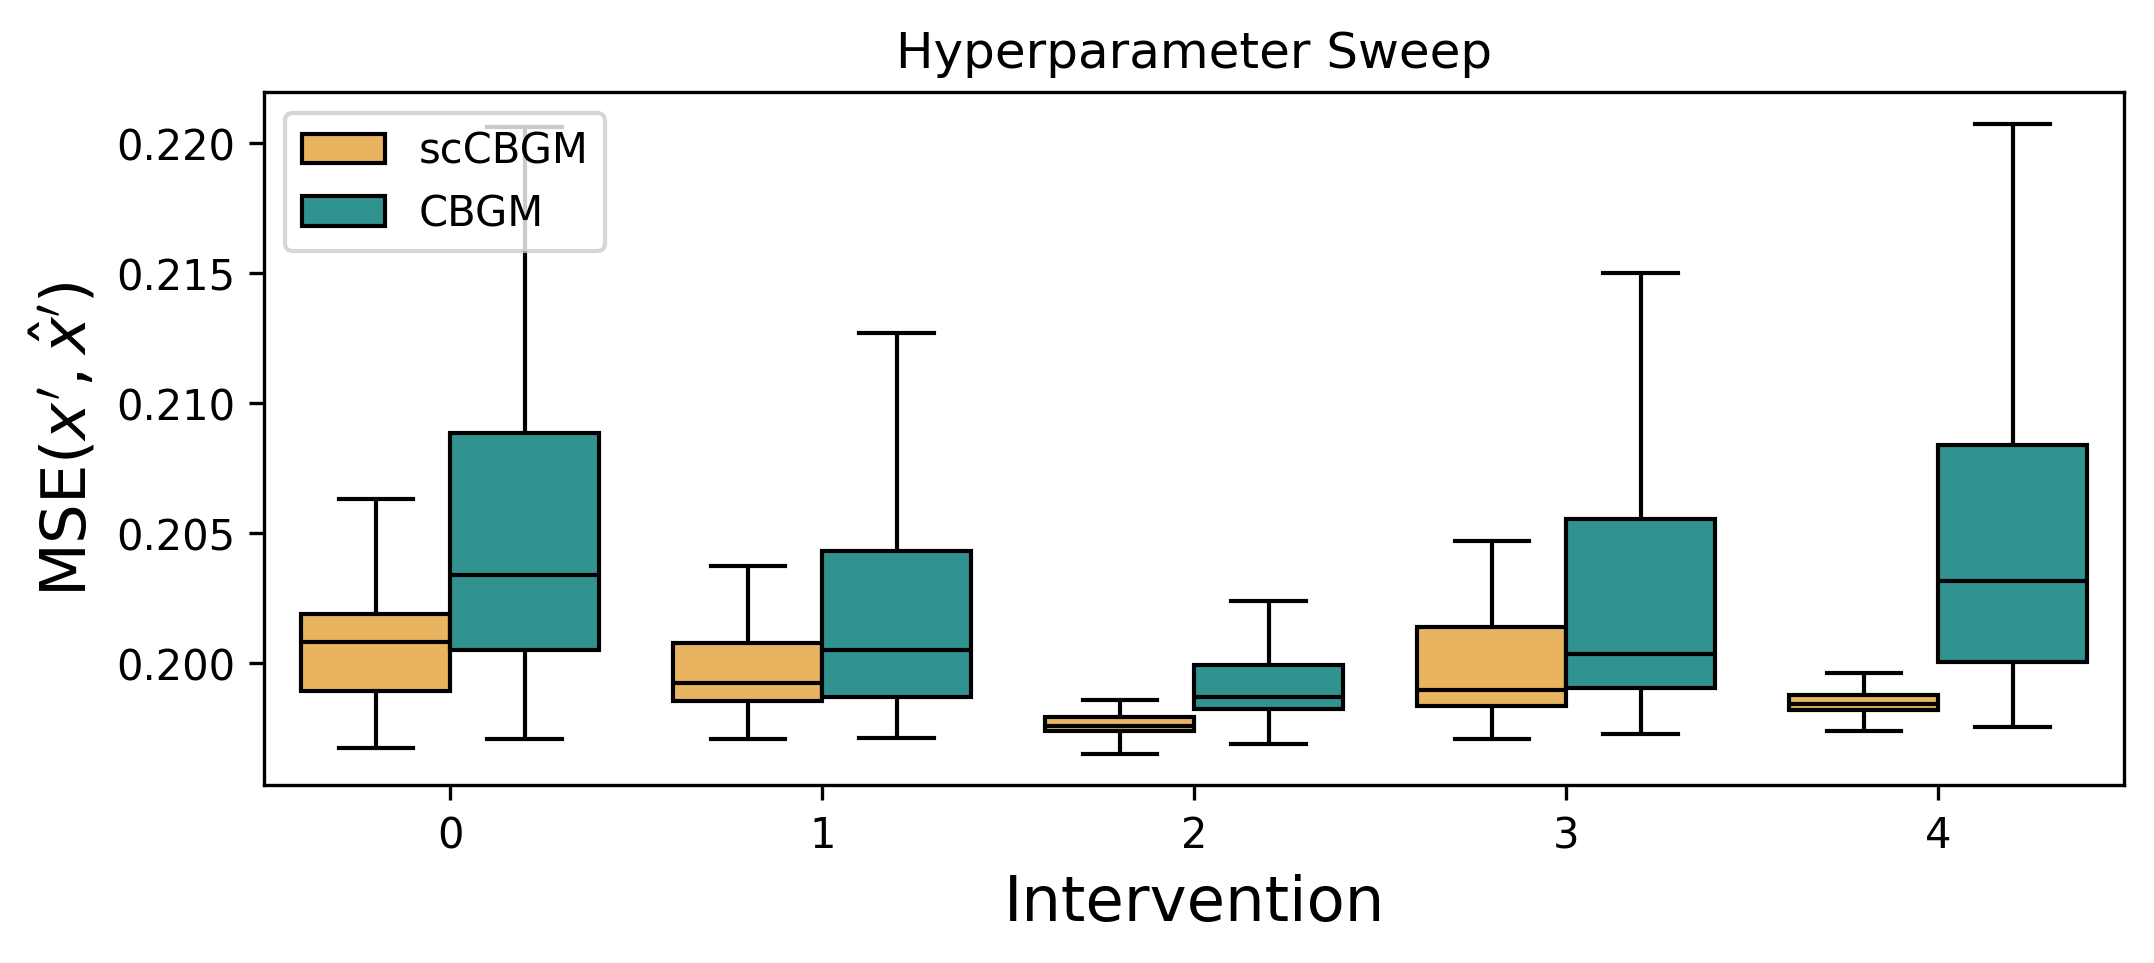

In [36]:
fix, ax = plt.subplots(1, 1, figsize=(8, 3), dpi = 300)
sns.boxplot(
    plot_df,
    x="intervention_num",
    y="MSE_intervened",
    hue="model",
    showfliers=False,
    ax=ax,
    palette=cmap,
    boxprops=dict(edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="black")
)

ax.legend(loc="upper left")
ax.set_xlabel("Intervention", fontsize=15)
ax.set_ylabel(r"$\text{MSE}(x',\hat{x}')$", fontsize=15)
ax.set_title("Hyperparameter Sweep")
plt.show()